In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob, iglob
from scipy.stats import gaussian_kde
import seaborn as sns

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('deep')

# Look at some basic qc information about the experiments

In [3]:
qcs = np.array(glob('other_cells_methods/*/qc_metrics/*.txt'), dtype=str)
qcs.sort()
qcs = qcs.reshape((10, 8))

In [4]:
dfs = []
for qc in qcs:
    df = []
    for q in qc:
        df.append(pd.read_table(q, index_col=0))
    tmp = pd.concat(df, axis=1)
    dfs.append(tmp)

sample_info = pd.concat(dfs)
sample_info.head(2)

,dup_level,frac_open,frip,library_size,mapping_rate,mt_content,sequencing_depth,uniq_frags
cell,,,,,,,,
c1_K562_chip1_01,0.924489,0.042205,0.517288,7693.0,94.01,0.620694,123268,2918.0
c1_K562_chip1_02,0.937314,0.444229,0.123374,50363.0,95.61,0.058714,904702,47406.0


In [5]:
sample_info['batch'] = sample_info.index.str.extract('(.*)_[0-9]+', expand=False)

Text(3.19444,0.5,'Overall alignment rate%')

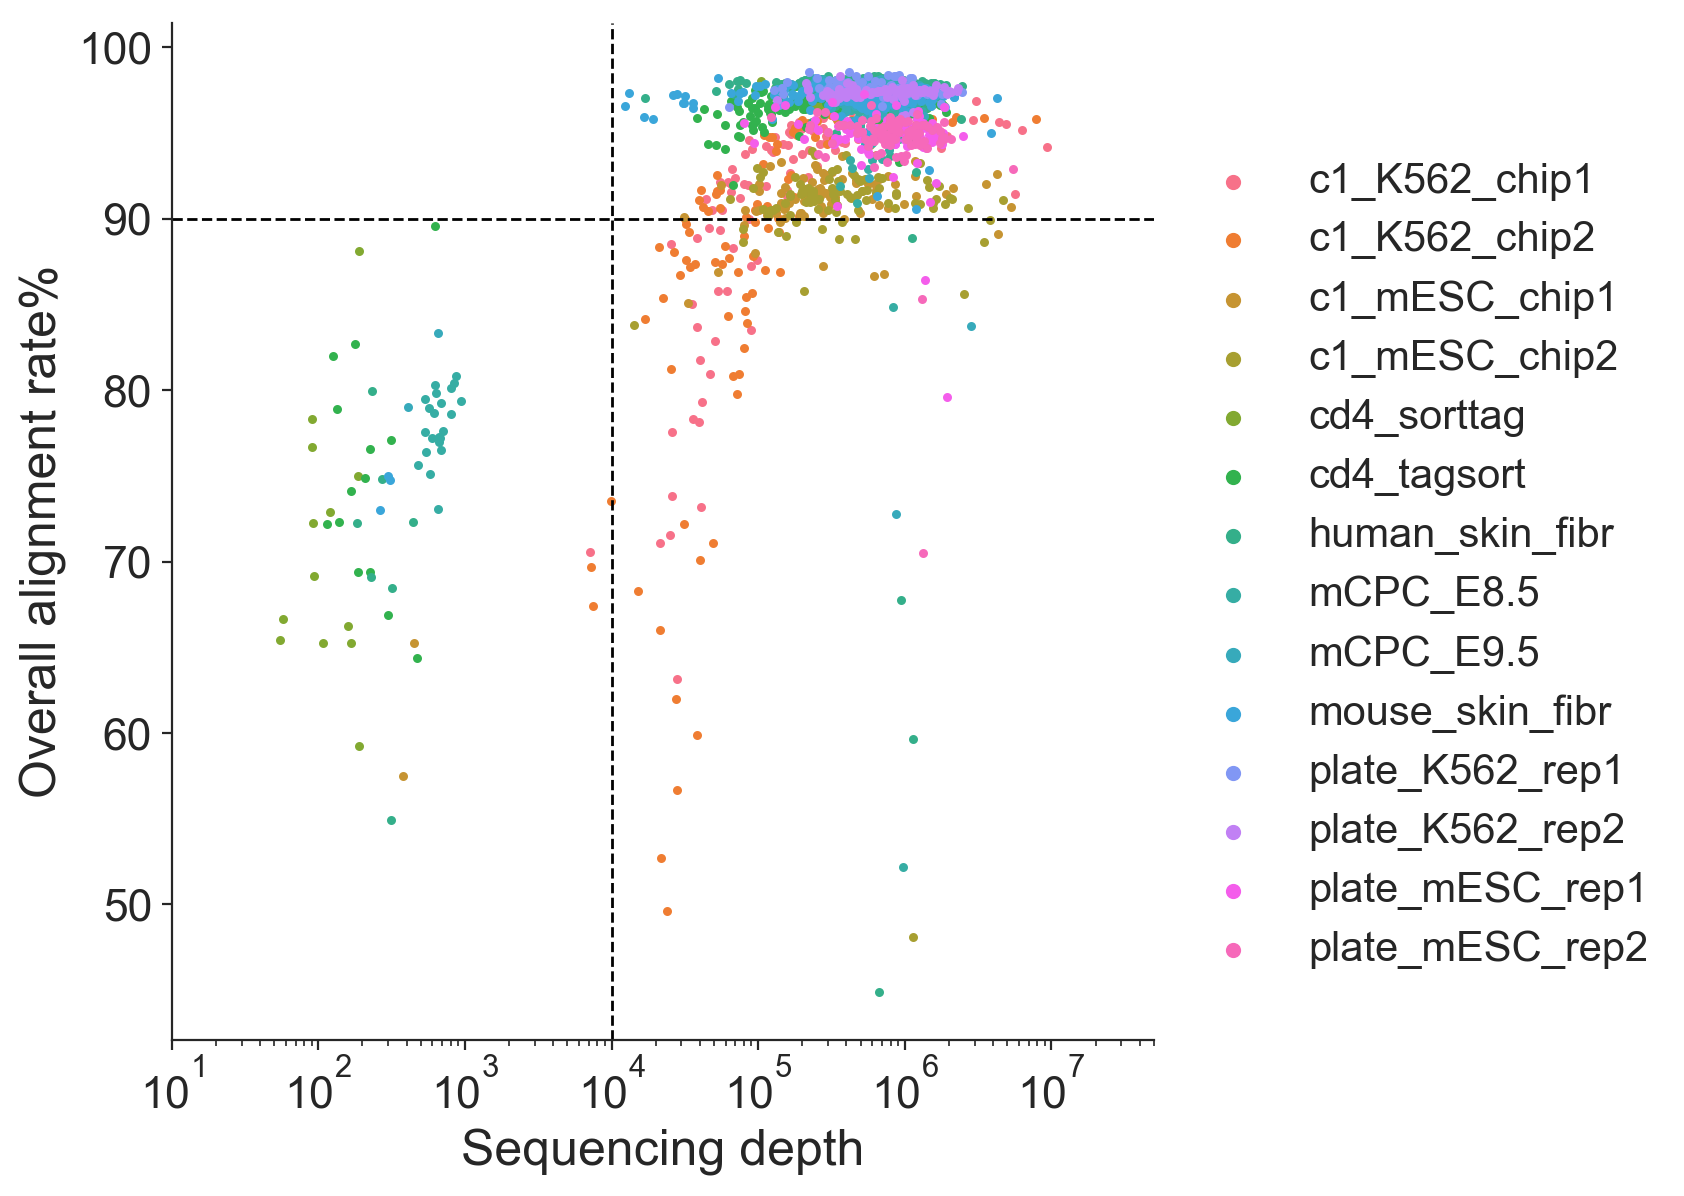

In [6]:
g = sns.FacetGrid(sample_info, hue='batch', height=6)
g.map(plt.scatter, 'sequencing_depth', 'mapping_rate', s=5)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

g.ax.legend(bbox_to_anchor=[1, .9], frameon=False)
g.ax.axhline(y=90, xmin=0, xmax=1, ls='dashed', c='k', lw=1.)
g.ax.axvline(x=1e4, ymin=0, ymax=1, ls='dashed', c='k', lw=1.)

g.ax.set_xlabel('Sequencing depth')
g.ax.set_ylabel('Overall alignment rate%')

In [7]:
all_median = sample_info.groupby('batch').median()
all_median

,dup_level,frac_open,frip,library_size,mapping_rate,mt_content,sequencing_depth,uniq_frags
batch,,,,,,,,
c1_K562_chip1,0.943457,0.050603,0.348685,6792.0,93.840,0.391514,157847.5,3264.0
c1_K562_chip2,0.946277,0.023363,0.305319,3109.0,90.135,0.329722,83739.5,1888.5
c1_mESC_chip1,0.895222,0.111854,0.227012,23183.5,91.310,0.069826,272739.0,20735.0
c1_mESC_chip2,0.901824,0.110492,0.184076,25154.5,91.215,0.047815,339823.0,22795.5
cd4_sorttag,0.959504,0.264682,0.712929,25830.0,97.365,0.016639,682727.5,25056.5
cd4_tagsort,0.952881,0.299732,0.689794,30953.0,96.690,0.015206,718120.5,30368.5
human_skin_fibr,0.875312,0.219900,0.601531,60458.5,97.870,0.016715,533802.5,59068.0
mCPC_E8.5,0.836070,0.261021,0.520305,104608.5,97.210,0.123606,739965.5,92276.0
mCPC_E9.5,0.852577,0.251955,0.526268,88776.0,97.390,0.129297,688425.5,77785.0


# Have a look at the comparison between c1 and plate

In [8]:
cmp_idx = (sample_info.index.str.startswith('c1') | sample_info.index.str.startswith('plate'))
t4_idx = sample_info.index.str.startswith('cd4').copy()
compare = sample_info.loc[cmp_idx,].copy()
others = sample_info.loc[np.logical_not(cmp_idx|t4_idx),].copy()

compare.replace({'batch' : {'c1_K562_chip1' : 'K562 C1 rep1 (n=96)',
                            'c1_K562_chip2' : 'K562 C1 rep2 (n=96)',
                            'c1_mESC_chip1' : 'mESC C1 rep1 (n=96)',
                            'c1_mESC_chip2' : 'mESC C1 rep2 (n=96)',
                            'plate_K562_rep1' : 'K562 plate rep1 (n=96)',
                            'plate_K562_rep2' : 'K562 plate rep2 (n=96)',
                            'plate_mESC_rep1' : 'mESC plate rep1 (n=96)',
                            'plate_mESC_rep2' : 'mESC plate rep2 (n=96)'}},
                inplace=True)

In [9]:
c1_plate_median = compare.groupby('batch').median()
c1_plate_median

,dup_level,frac_open,frip,library_size,mapping_rate,mt_content,sequencing_depth,uniq_frags
batch,,,,,,,,
K562 C1 rep1 (n=96),0.943457,0.050603,0.348685,6792.0,93.840,0.391514,157847.5,3264.0
K562 C1 rep2 (n=96),0.946277,0.023363,0.305319,3109.0,90.135,0.329722,83739.5,1888.5
K562 plate rep1 (n=96),0.972131,0.132162,0.499907,14980.0,97.510,0.179726,599234.5,10555.5
K562 plate rep2 (n=96),0.942184,0.307729,0.436482,42245.0,97.390,0.061254,848197.5,38019.5
mESC C1 rep1 (n=96),0.895222,0.111854,0.227012,23183.5,91.310,0.069826,272739.0,20735.0
mESC C1 rep2 (n=96),0.901824,0.110492,0.184076,25154.5,91.215,0.047815,339823.0,22795.5
mESC plate rep1 (n=96),0.943482,0.201884,0.421075,38714.5,95.040,0.051184,829274.5,37250.0
mESC plate rep2 (n=96),0.945561,0.219249,0.415647,39956.0,95.030,0.053550,823307.5,37506.5


In [10]:
np.linspace(0.0, 0.5, 6)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

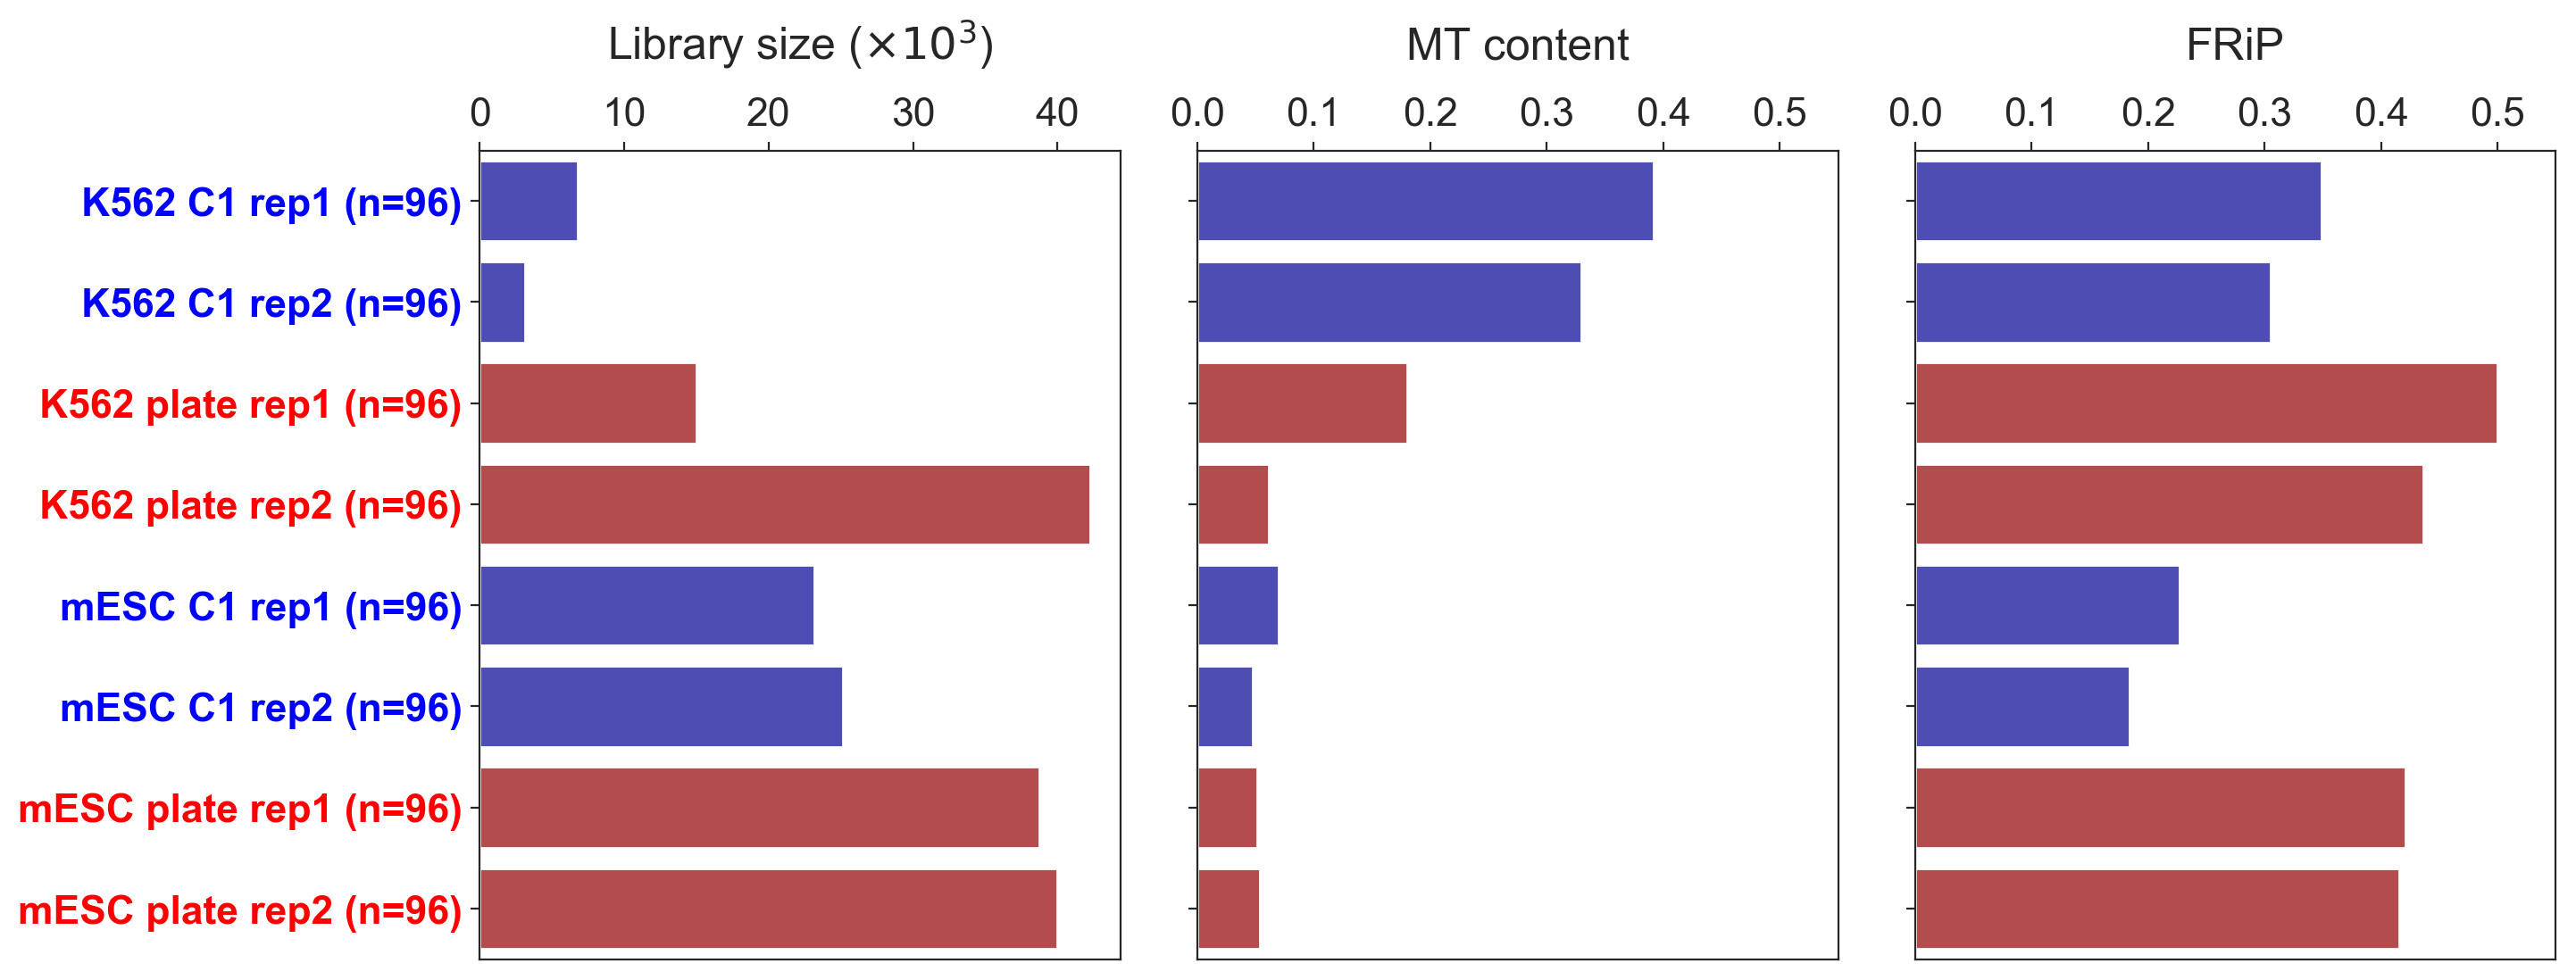

In [11]:
fig, ax = plt.subplots(figsize=(15, 6), ncols=3, nrows=1,
                       sharey=True, gridspec_kw={'wspace' : 0.12})

colors = ['#0000ff', '#0000ff', '#ff0000', '#ff0000',
          '#0000ff', '#0000ff', '#ff0000', '#ff0000']

for i,j,k in zip(['library_size', 'mt_content', 'frip'],
                 ax,
                 [r'Library size ($\times 10^3$)', 'MT content', 'FRiP']):
    sns.barplot(y=c1_plate_median.index, x=i, data=c1_plate_median,
                palette=sns.color_palette(colors), ax=j, orient='h', saturation=.4)
    j.xaxis.set_ticks_position('top')
    j.xaxis.set_label_position('top')
    j.set_xlabel(k, labelpad=15)
    for c, l in zip(colors, j.get_yticklabels()):
        l.set_color(c)
        l.set_weight('bold')
    j.set_ylabel('')

ax[0].set_xticks([0, 1e4, 2e4, 3e4, 4e4])
ax[0].set_xticklabels(['0', '10', '20', '30', '40'])

for i in [1, 2]:
    ax[i].set_xticks(np.linspace(0.0, 0.5, 6))
    ax[i].set_xticklabels([str(round(t, 2)) for t in np.linspace(0.0, 0.5, 6)])
    ax[i].set_xlim(0, 0.55)

plt.savefig('figures/c1_vs_plate_side_by_side_bar.pdf',
            bbox_inches='tight', transparent=True)

In [12]:
other_median = others.groupby('batch').median()
other_median = other_median.loc[['human_skin_fibr', 'mouse_skin_fibr', 'mCPC_E8.5', 'mCPC_E9.5'],]
other_median

,dup_level,frac_open,frip,library_size,mapping_rate,mt_content,sequencing_depth,uniq_frags
batch,,,,,,,,
human_skin_fibr,0.875312,0.219900,0.601531,60458.5,97.870,0.016715,533802.5,59068.0
mouse_skin_fibr,0.899095,0.205388,0.498879,52747.0,97.215,0.029675,561099.5,51305.0
mCPC_E8.5,0.836070,0.261021,0.520305,104608.5,97.210,0.123606,739965.5,92276.0
mCPC_E9.5,0.852577,0.251955,0.526268,88776.0,97.390,0.129297,688425.5,77785.0


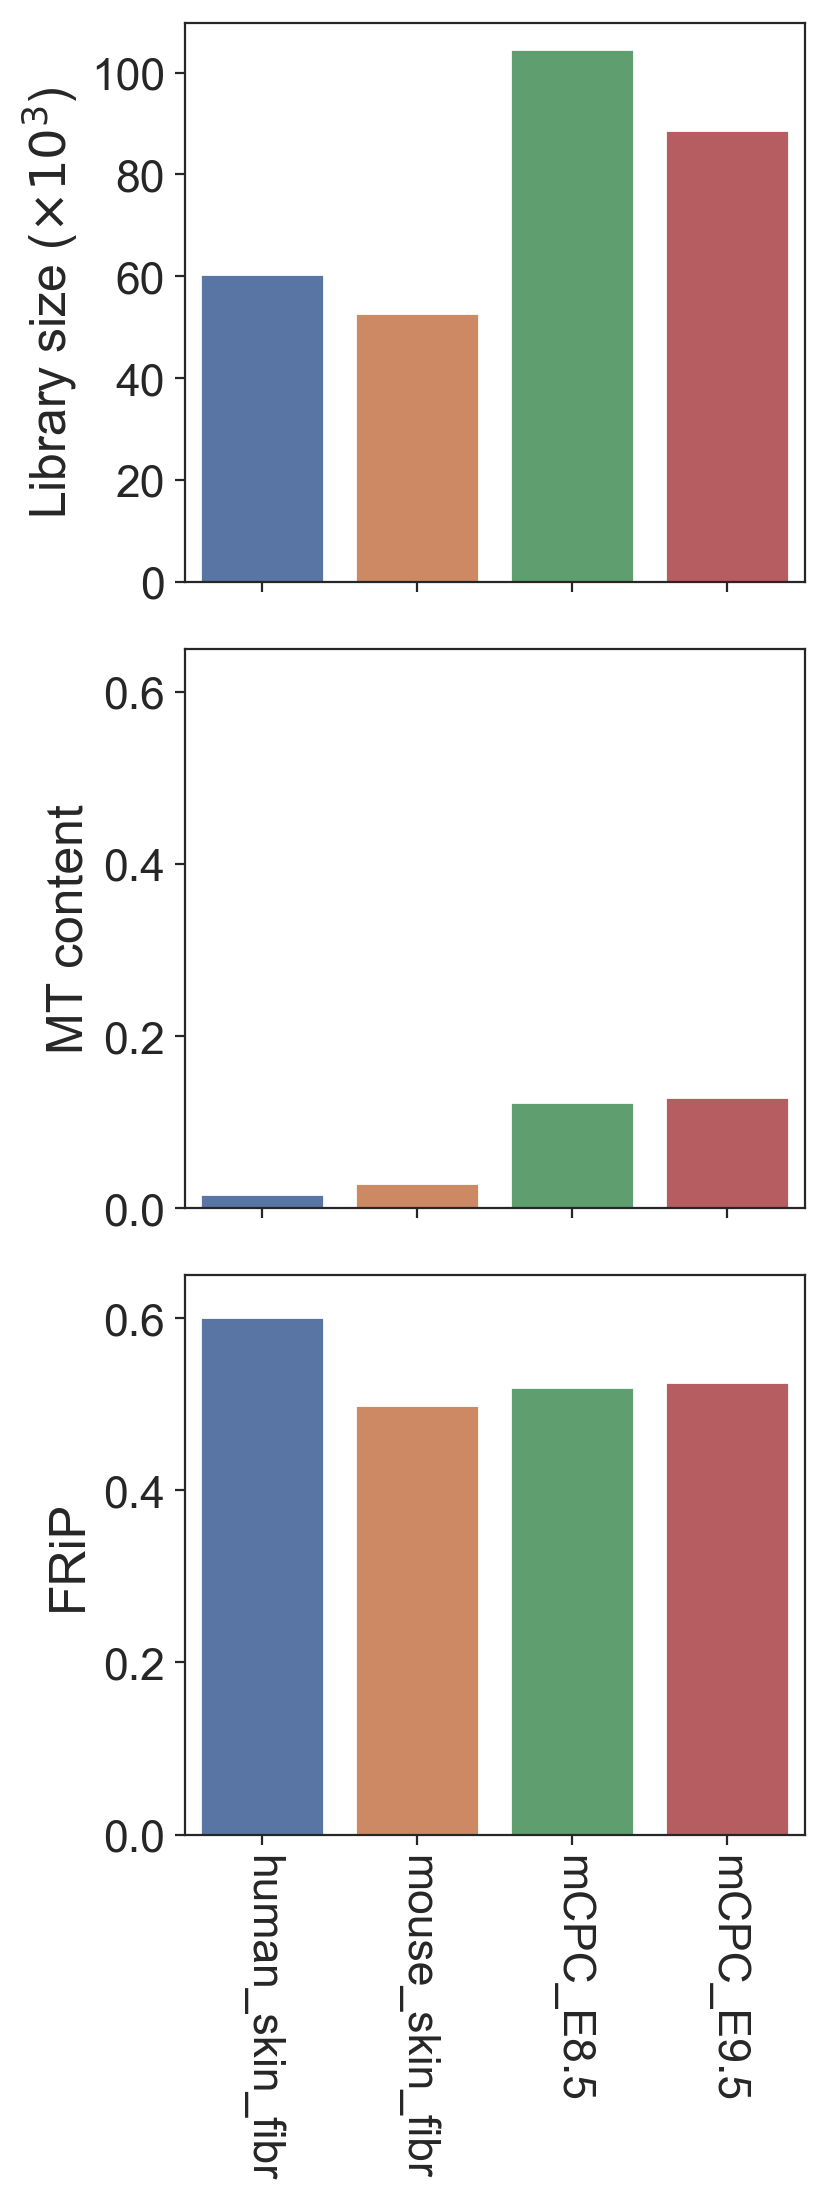

In [13]:
fig, ax = plt.subplots(figsize=(4, 12), ncols=1, nrows=3,
                       sharex=True, gridspec_kw={'hspace' : 0.12})

for i,j,k in zip(['library_size', 'mt_content', 'frip'],
                 ax,
                 [r'Library size ($\times 10^3$)', 'MT content', 'FRiP']):
    sns.barplot(x=other_median.index, y=i, data=other_median,
                palette='deep', ax=j, orient='v')
    j.set_ylabel(k)
    j.set_xlabel('')

xtls = ax[2].get_xticklabels()
for xtl in xtls:
    xtl.set_rotation(270)

ax[0].set_yticks(range(0, 120000, 20000))
ax[0].set_yticklabels(str(i) for i in range(0, 120, 20))

for i in [1, 2]:
    ax[i].set_yticks(np.linspace(0.0, 0.6, 4))
    ax[i].set_yticklabels([str(round(t, 2)) for t in np.linspace(0.0, 0.6, 4)])
    ax[i].set_ylim(0, 0.65)

# plt.savefig('figures/other_cells_tissues_side_by_side_bar.pdf',
#             bbox_inches='tight', transparent=True)

(0, 1200)

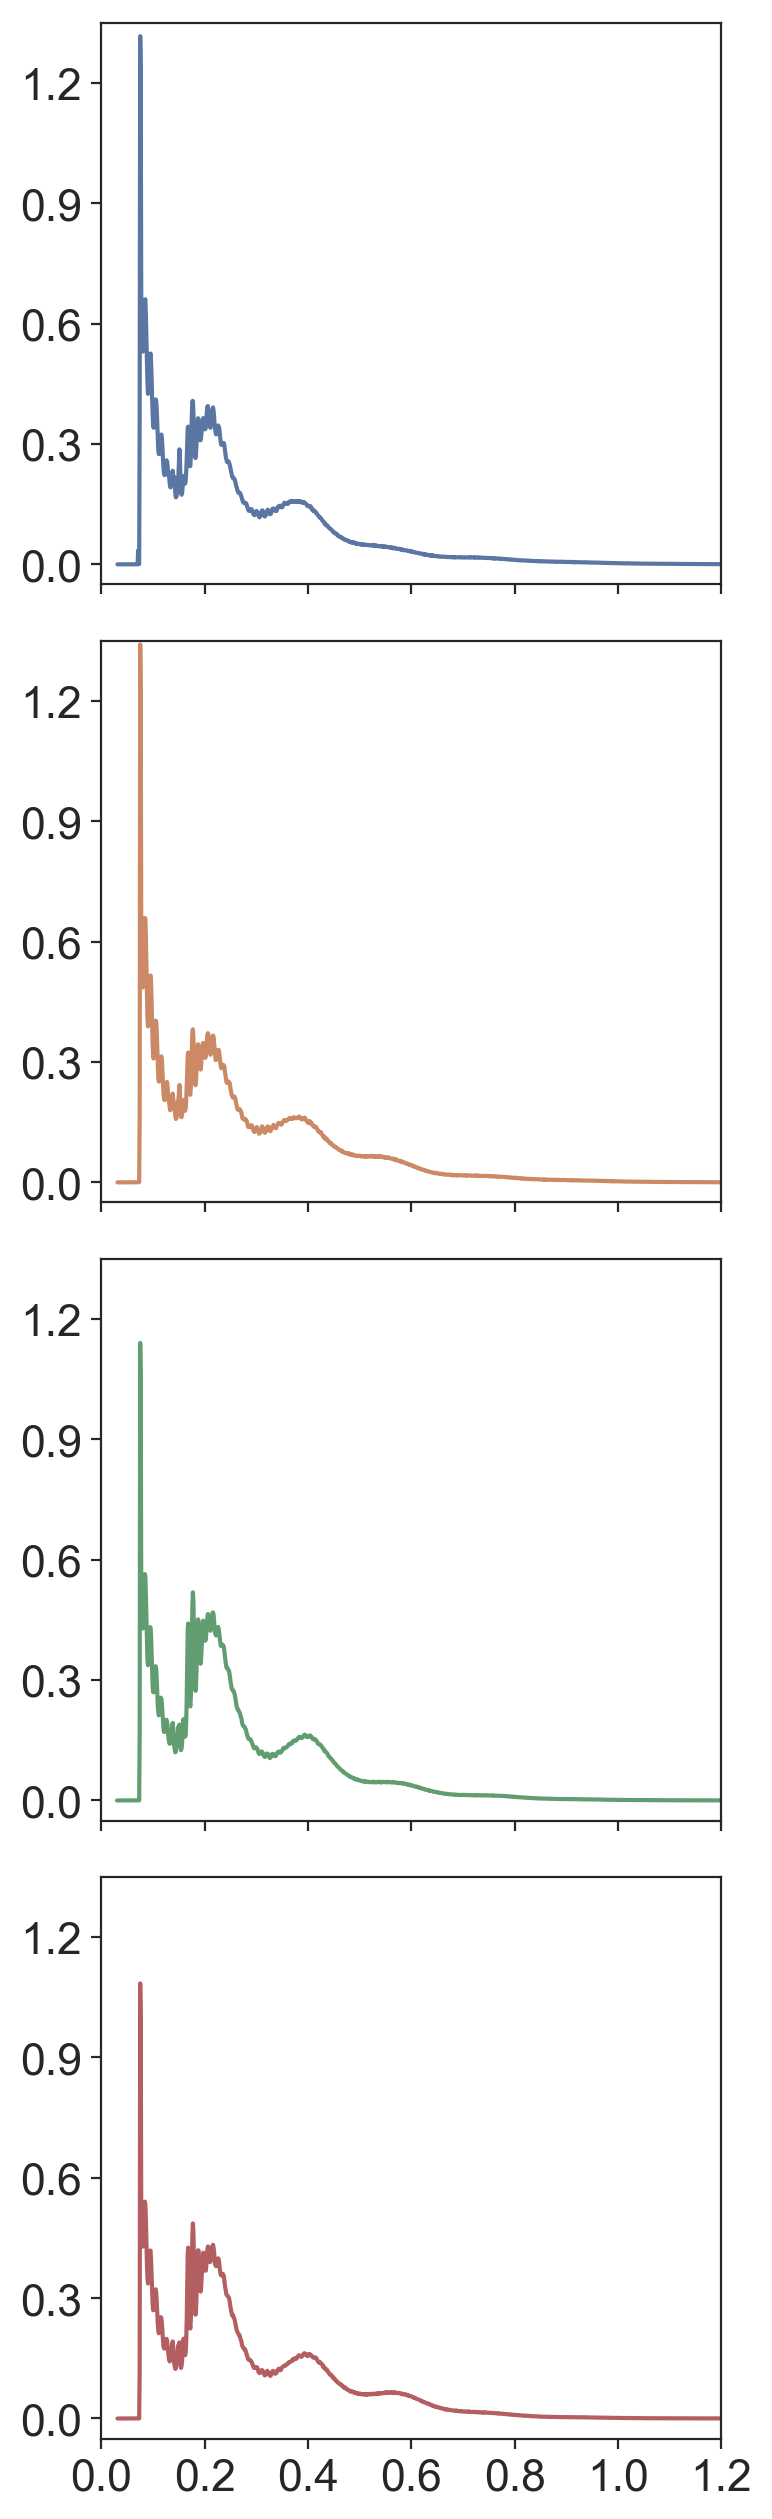

In [14]:
fig, ax = plt.subplots(figsize=(4, 16), ncols=1, nrows=4,
                       sharex=True, sharey=True,
                       gridspec_kw={'hspace' : 0.1})

for i,j,c in zip(['human_skin_fibr', 'mouse_skin_fibr',
                  'mouse_cpc_e8.5', 'mouse_cpc_e9.5'],
                  ax,
                  ['#5a76a2', '#cb8966', '#619d70', '#b35e61']
                 ):
    isize = pd.read_table('other_cells_methods/' + i + '/aggregate/f2q30_merged_pmd_isize.hist',
                          sep=' ', header=None, names=['count', 'size'])
    j.plot(isize['size'],
           isize['count'] / isize['count'].sum() * 100,
           color=c, lw=1.5)
    j.set_yticks(np.linspace(0, 1.2, 5))
    j.set_yticklabels(str(round(t, 2)) for t in np.linspace(0, 1.2, 5))
    j.set_ylim(-0.05, 1.35)
    j.set_xlabel('')

ax[3].set_xticks(range(0,1400,200))
ax[3].set_xticklabels(str(round(t/1000, 2)) for t in range(0,1400,200))
ax[3].set_xlim(0,1200)

# plt.savefig('figures/other_cells_tissues_isize.pdf',
#             bbox_inches='tight', transparent=True)

Text(0,0.5,'')

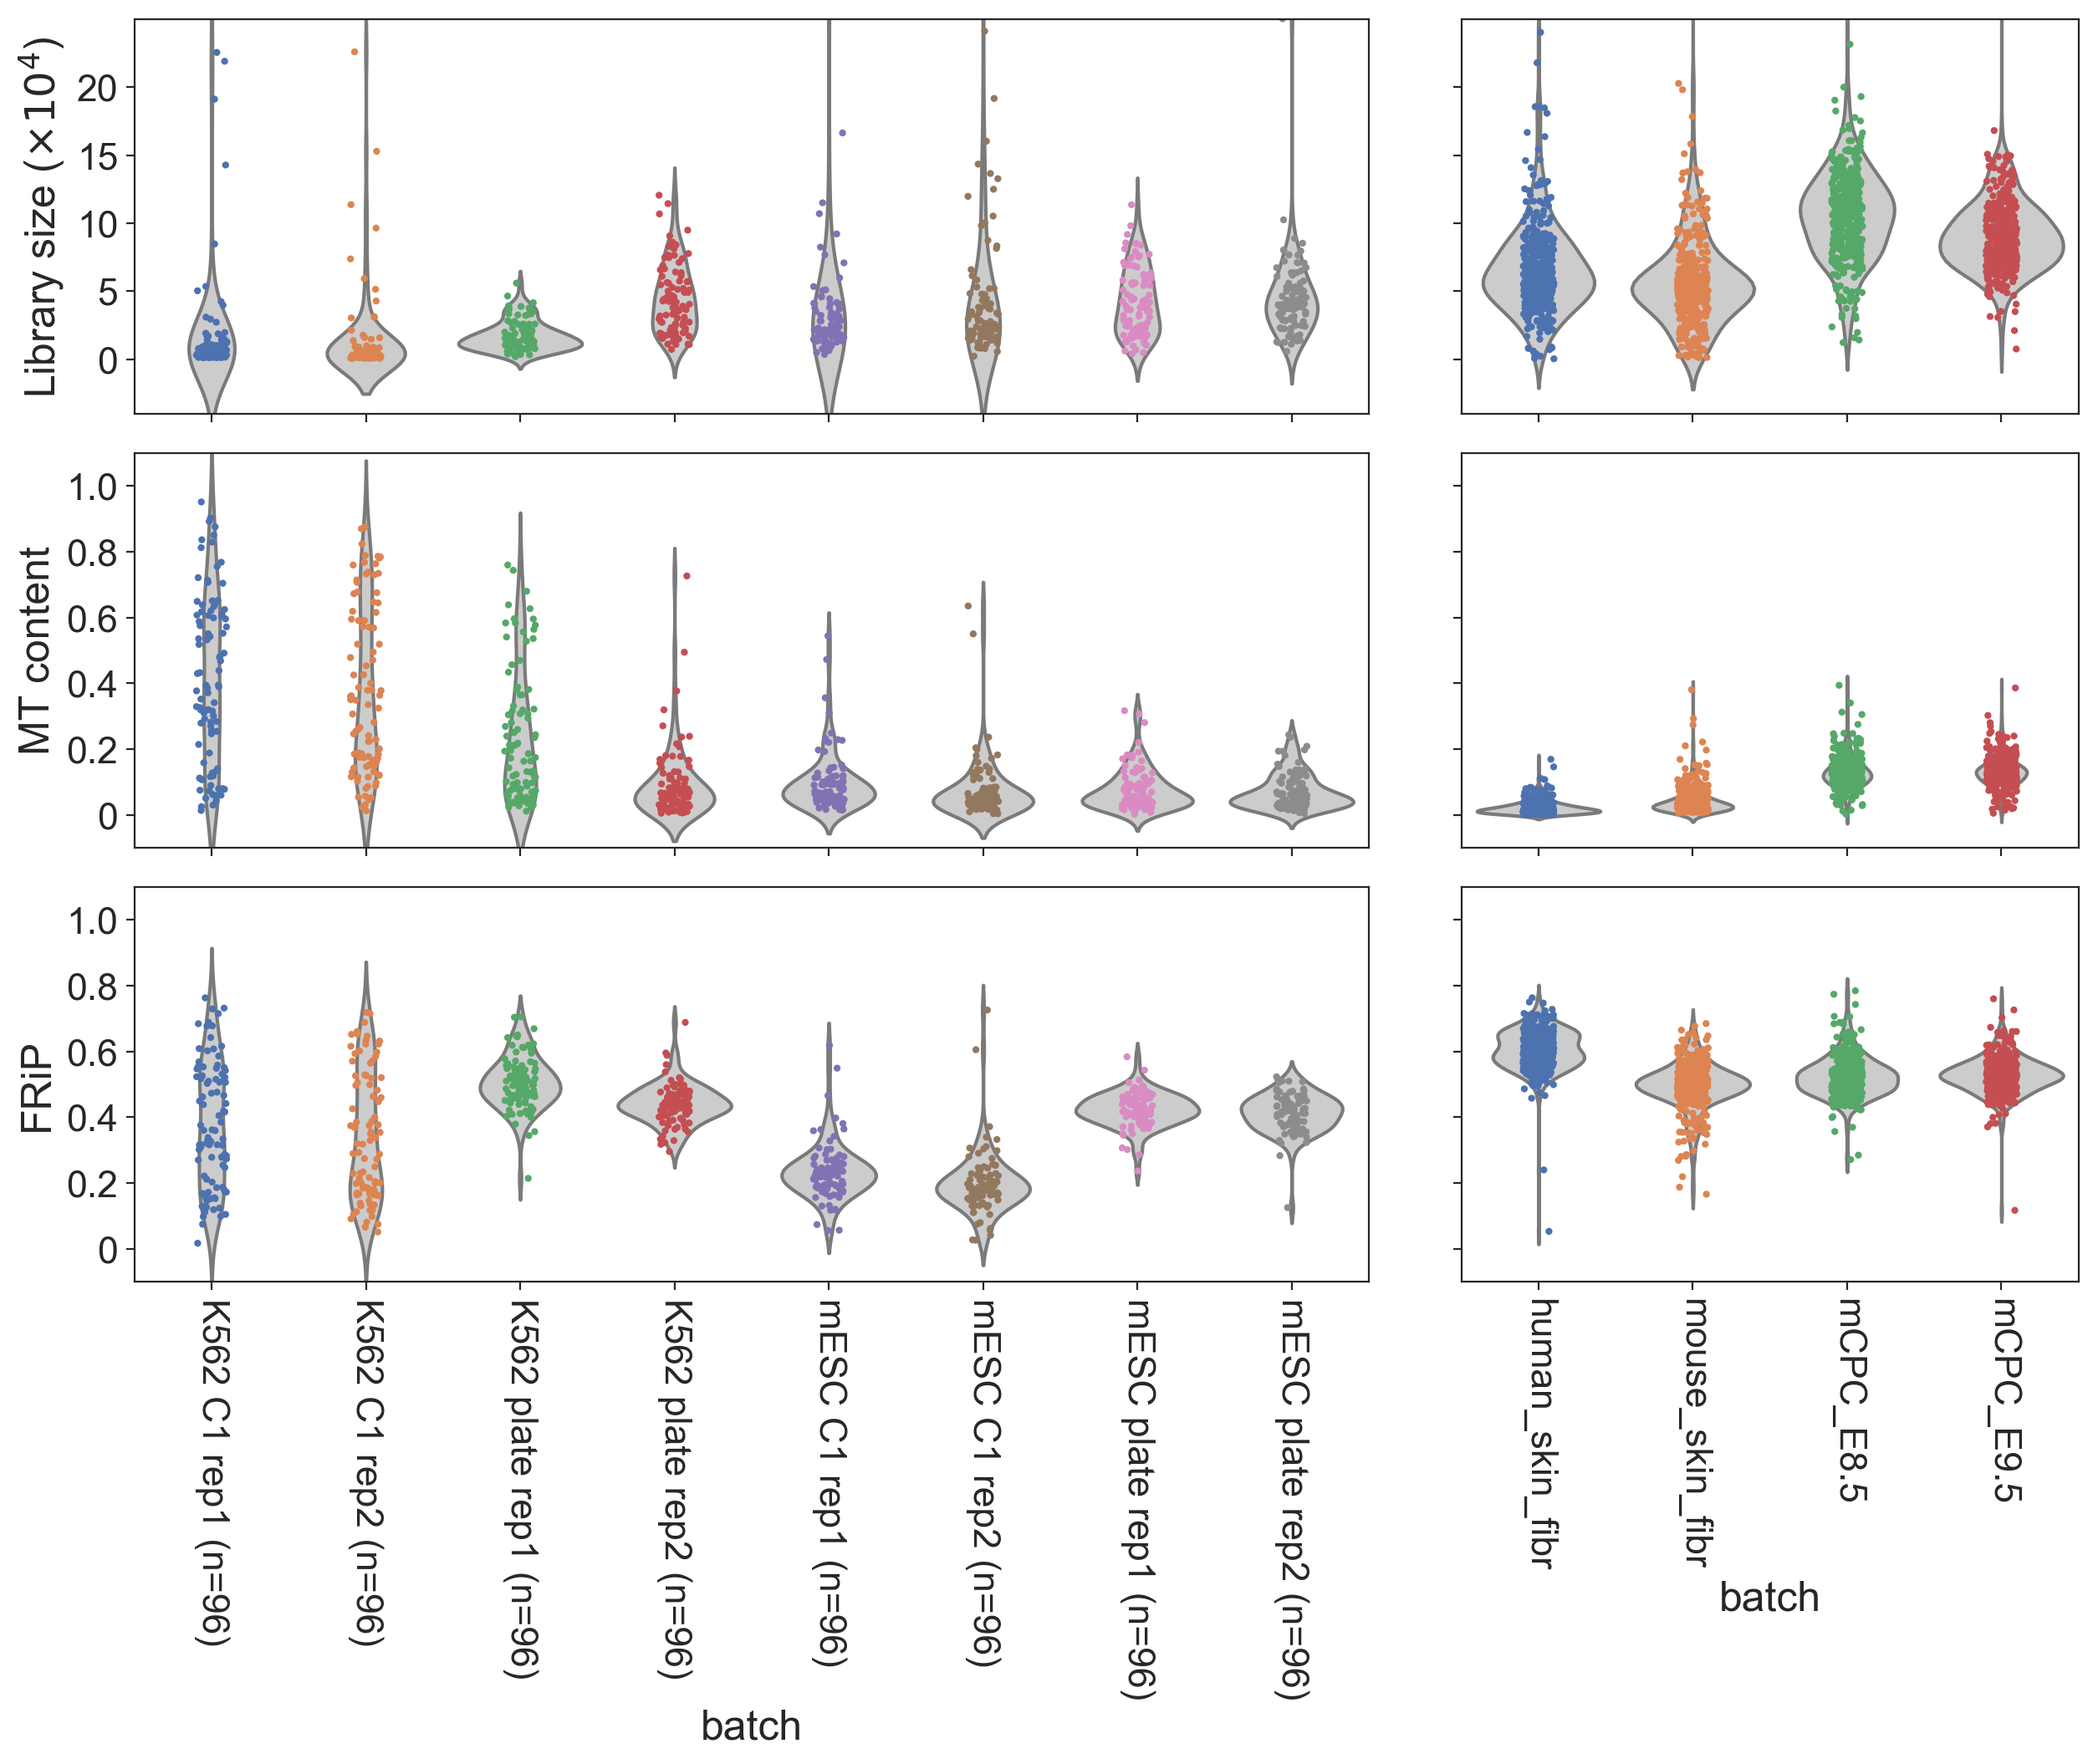

In [15]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=3,
                       sharex='col', sharey='row',
                       gridspec_kw={'width_ratios' : [2, 1],
                                    'wspace' : 0.1, 'hspace' : 0.1})

for qc, p in zip(['library_size', 'mt_content', 'frip'], ax):
    
    sns.violinplot(x='batch', y=qc, data=compare,
                   inner=None, color='.8', width=.8, ax=p[0],
                   order=c1_plate_median.index, zorder=1)
    sns.stripplot(x='batch', y=qc, data=compare, rasterized=True,
                  jitter=True, ax=p[0], s=3, zorder=2,
                  order=c1_plate_median.index)

    sns.violinplot(x='batch', y=qc, data=others, inner=None,
                   color='.8', width=.8, ax=p[1], zorder=1,
                   order=other_median.index)
    sns.stripplot(x='batch', y=qc, data=others, rasterized=True,
                  jitter=True, ax=p[1], s=3, zorder=2,
                  order=other_median.index)

    xtls = p[0].get_xticklabels() + p[1].get_xticklabels()

    for xtl in xtls:
        xtl.set_rotation(270)

ax[0][0].set_ylim(-40000, 250000)
ax[0][0].set_yticks(range(0, 250000, 50000))
ax[0][0].set_yticklabels(['0', '5', '10', '15', '20'])
ax[0][0].set_ylabel(r'Library size ($\times 10^4$)')
ax[0][0].set_xlabel('')
ax[0][1].set_ylabel('')
ax[0][1].set_xlabel('')

ax[1][0].set_ylim(-.1, 1.1)
ax[1][0].set_yticks((0, .2, .4, .6, .8, 1.0))
ax[1][0].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax[1][0].set_ylabel('MT content')
ax[1][0].set_xlabel('')
ax[1][1].set_ylabel('')
ax[1][1].set_xlabel('')


ax[2][0].set_ylim(-.1, 1.1)
ax[2][0].set_yticks((0, .2, .4, .6, .8, 1.0))
ax[2][0].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax[2][0].set_ylabel('FRiP')
ax[2][1].set_ylabel('')

# plt.savefig('figures/c1_vs_plate_side_by_side_violin.pdf',
#             bbox_inches='tight', transparent=True)

In [16]:
t4_info = sample_info.loc[t4_idx,]
t4_info.groupby('batch').median()

,dup_level,frac_open,frip,library_size,mapping_rate,mt_content,sequencing_depth,uniq_frags
batch,,,,,,,,
cd4_sorttag,0.959504,0.264682,0.712929,25830.0,97.365,0.016639,682727.5,25056.5
cd4_tagsort,0.952881,0.299732,0.689794,30953.0,96.690,0.015206,718120.5,30368.5


Text(0.5,0,'')

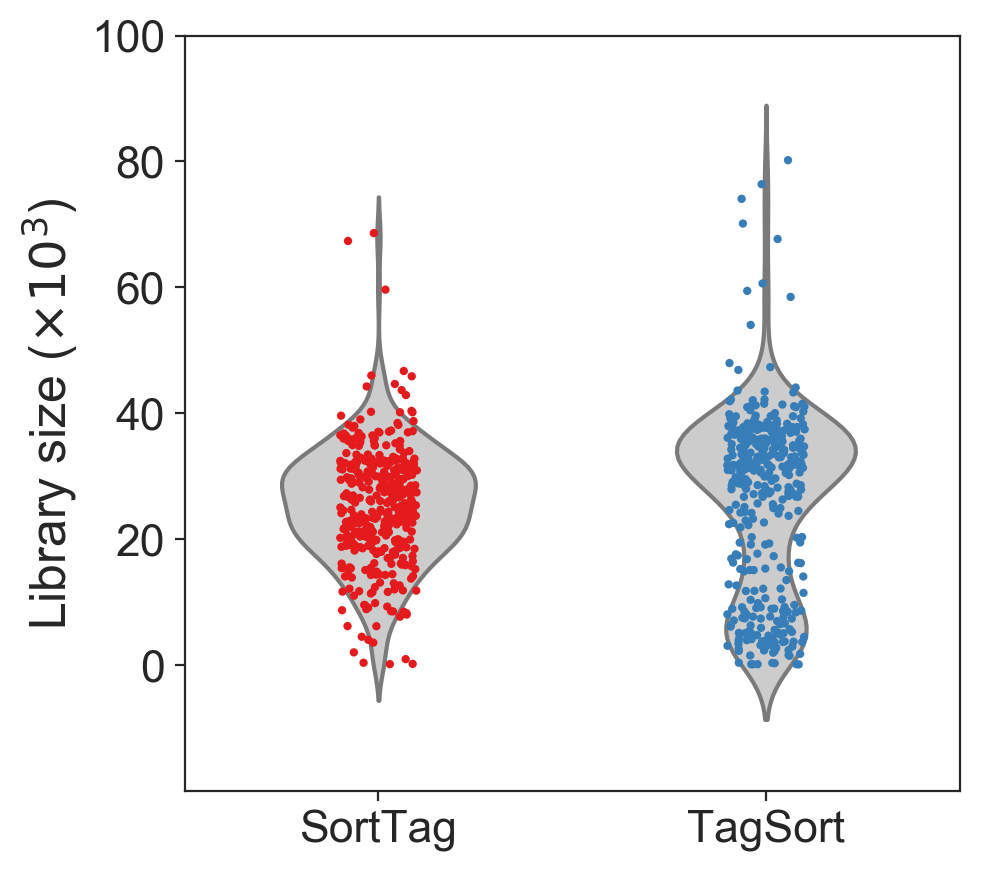

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

sns.violinplot(x='batch', y='library_size', data=t4_info,
               inner=None, color='.8', width=.5, ax=ax, zorder=1)
sns.stripplot(x='batch', y='library_size', data=t4_info, palette='Set1',
              rasterized=True, jitter=True, ax=ax, s=3, zorder=2)

ax.set_ylim(-20000, 100000)
ax.set_yticks(range(0, 120000, 20000))
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.set_ylabel(r'Library size ($\times 10^3$)')
ax.set_xticklabels(['SortTag', 'TagSort'])
ax.set_xlabel('')

# plt.savefig('figures/cd4_strategy_comparison_violin.pdf',
#             transparent=True, bbox_inches='tight')

In [18]:
!head -3 other_cells_methods/homer_normed_tagcount_in_cd4_union_peaks.txt

PeakID (cmd=annotatePeaks.pl cd4_union_peaks.bed mm10 -size given -log -fragLength 1 -noann -nogene -d cd4_sorttag/aggregate/f2q30_merged_tagdir cd4_tagsort/aggregate/f2q30_merged_tagdir)	Chr	Start	End	Strand	Peak Score	Focus Ratio/Region Size	cd4_sorttag/aggregate/f2q30_merged_tagdir Tag Count in given bp (18108824.0 Total, normalization factor = 0.55, effective total = 10000000)	cd4_tagsort/aggregate/f2q30_merged_tagdir Tag Count in given bp (19076224.0 Total, normalization factor = 0.52, effective total = 10000000)
cd4_upk_34896	chr5	143630738	143631121	+	0	NA	5.97	6.42
cd4_upk_15905	chr15	76229396	76229703	+	0	NA	6.20	5.98


In [19]:
tags = pd.read_table('other_cells_methods/homer_normed_tagcount_in_cd4_union_peaks.txt',
                     header=None, skiprows=1, usecols=[0, 7,8], names=['pid', 'SortTag', 'TagSort'],
                     index_col='pid')
tags.head()

,SortTag,TagSort
pid,,
cd4_upk_34896,5.97,6.42
cd4_upk_15905,6.20,5.98
cd4_upk_1529,3.46,2.46
cd4_upk_26399,4.01,3.31
cd4_upk_19772,4.52,4.50


In [20]:
tags.corr()

,SortTag,TagSort
SortTag,1.000000,0.963806
TagSort,0.963806,1.000000


In [21]:
# Thank Joe Kington from Stack Overflow
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

# Calculate the point density
xy = np.vstack([tags.SortTag.values, tags.TagSort.values])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = tags.SortTag.values[idx], tags.TagSort.values[idx], z[idx]

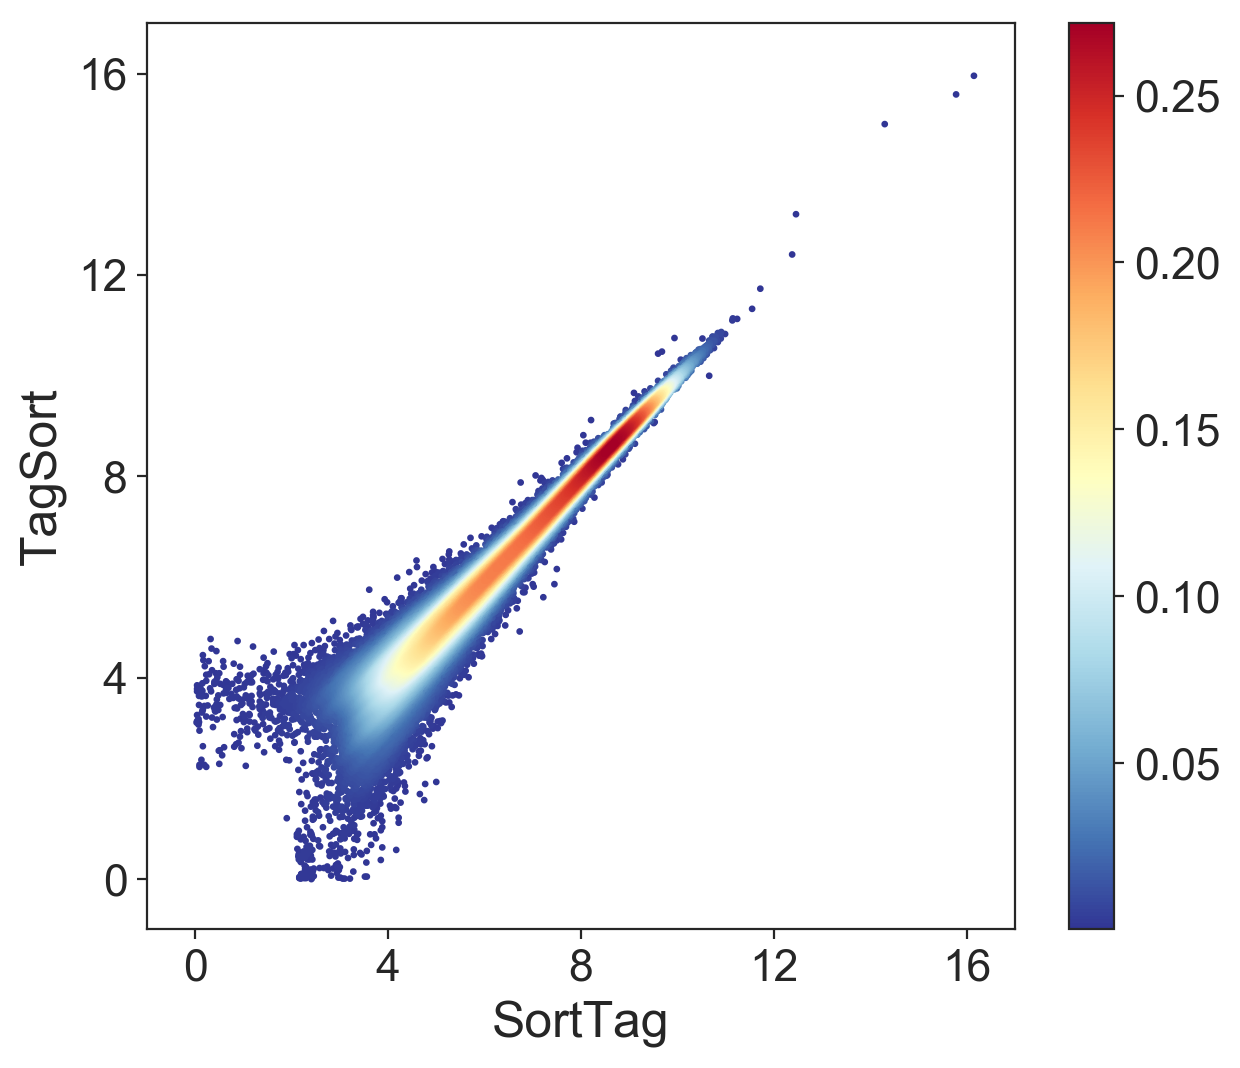

In [22]:
fig, ax = plt.subplots(figsize=(7,6))

p = ax.scatter(x, y, s=2, c=z, rasterized=True, cmap='RdYlBu_r')

ax.set_xticks(range(0, 20, 4))
ax.set_xticklabels(str(t) for t in range(0, 20, 4))

ax.set_yticks(range(0, 20, 4))
ax.set_yticklabels(str(t) for t in range(0, 20, 4))

ax.set_xlim(-1, 17)
ax.set_ylim(-1, 17)

ax.set_xlabel('SortTag')
ax.set_ylabel('TagSort')

plt.colorbar(p)

# plt.savefig('figures/cd4_strategy_comparison_scatter.pdf',
#             bbox_inches='tight', transparent=True)